In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import xarray as xr
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data, Dataset
from Trainer_loocv import Trainer
from utils import get_distance, draw_graph, nearest_neighbors_graph, plot_heatmap, dataset_generation
from GCN_Regression import GCN_RegressionModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data/final_data_mar.csv.gz')
df['time'] = pd.to_datetime(df['time'])

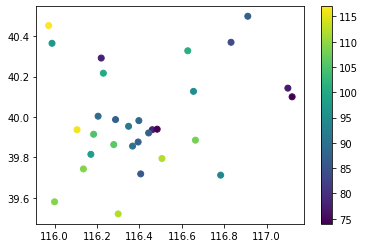

In [2]:
temp = df[df['time'] == '2014-05-01 00:00:00']
plt.scatter(temp['longitude'], temp['latitude'], c = temp['PM25_Concentration'])
plt.colorbar();

In [3]:
#Scaling
train = df[['latitude', 'longitude']]
scaler = MinMaxScaler().fit(train)
train = pd.DataFrame(scaler.transform(train),columns=list(train.columns))
df[list(train.columns)] = train[list(train.columns)]

test = df['PM25_Concentration'].values.reshape(-1,1)
scaler2 = MinMaxScaler()
df['PM25_Concentration'] = scaler2.fit_transform(test)

In [4]:
def loocv(timestamp):
    dataframe = []
    d = df[df["time"]==timestamp]
    G = nearest_neighbors_graph(d, 8)
    node_features, edge_index, y = dataset_generation(G)

    for super in list(G.nodes()):
        #         print(super)
        # Divide train and test masks based on the latitudes
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        test_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for j, node in list(enumerate(G.nodes)):
            if node!=super:
                train_mask[j] = True
            else:
                test_mask[j] = True

        data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask = test_mask)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = GCN_RegressionModel(2)
        trainer = Trainer(model = model, data = data, device = device, epochs=2500)
        trainer.train(lr=0.001)
        out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
        gnn_pred = out[data.test_mask].squeeze()
        gnn_pred = scaler2.inverse_transform(gnn_pred.detach().numpy().reshape(-1, 1))
        real = scaler2.inverse_transform(data.y[data.test_mask])
        gnn_rmse = np.sqrt(np.mean((gnn_pred - real)**2))
        
        actual = data.y[data.test_mask].squeeze().tolist()
        
        X_train = data.x[data.train_mask].numpy()
        y_train = data.y[data.train_mask].numpy().reshape(-1)
        X_test = data.x[data.test_mask].numpy()
        y_test = data.y[data.test_mask].numpy().reshape(-1)
        
        #RF        
        rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_pred = scaler2.inverse_transform(rf_pred.reshape(-1, 1))
        real = scaler2.inverse_transform(data.y[data.test_mask])
        rf_rmse = torch.sqrt(torch.mean((torch.tensor(rf_pred) - real)**2))
        
        #KNN
        knn_model = KNeighborsRegressor(n_neighbors = 8)
        knn_model.fit(X_train, y_train)
        knn_pred = knn_model.predict(X_test)
        knn_pred = scaler2.inverse_transform(knn_pred.reshape(-1, 1))
        knn_rmse = torch.sqrt(torch.mean((torch.tensor(knn_pred) - real)**2))
        
        #LR
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        lr_pred = scaler2.inverse_transform(lr_pred.reshape(-1, 1))
        lr_rmse = torch.sqrt(torch.mean((torch.tensor(lr_pred) - real)**2))
        
        #idw
        idw_model = KNeighborsRegressor(n_neighbors = 8, weights = 'distance')
        idw_model.fit(X_train, y_train)
        idw_pred = idw_model.predict(X_test)
        idw_pred = scaler2.inverse_transform(idw_pred.reshape(-1, 1))
        idw_rmse = torch.sqrt(torch.mean((torch.tensor(idw_pred) - real)**2))
        
        #Mean
        train_mean = torch.mean(data.y[data.train_mask])
        mean_pred = np.array(int(data.test_mask.sum())*[float(train_mean)])
        mean_pred = scaler2.inverse_transform(mean_pred.reshape(-1, 1))
        mean_rmse = np.sqrt(np.mean((mean_pred - real)**2))
        
        dataframe.append({
                            "node": G.nodes[super]["station"],
                            "lat": G.nodes[super]["latitude"],
                            "lon": G.nodes[super]["longitude"],
                            "pm": G.nodes[super]["pm"],
                            "knn rmse": float(knn_rmse),
                            "mean rmse": float(mean_rmse),
                            "idw rmse": float(idw_rmse),
                            "lr rmse": float(lr_rmse),
                            "rf rmse": float(rf_rmse),
                            "gnn rmse": float(gnn_rmse),
                            "actual": actual,
                            "knn pred": knn_pred[0],
                            "mean pred": mean_pred[0],
                            "idw pred": idw_pred[0],
                            "lr pred": lr_pred[0],
                            "rf pred": rf_pred[0],
                            "gnn pred": gnn_pred,    
                           })
    
    return dataframe

KNN RMSE:  9.963514584054549
Mean RMSE:  11.970014896988868
IDW RMSE:  8.779806523495747
RF RMSE:  8.333318009288236
LR RMSE:  9.237111300478379
GNN RMSE:  17.878048527489106


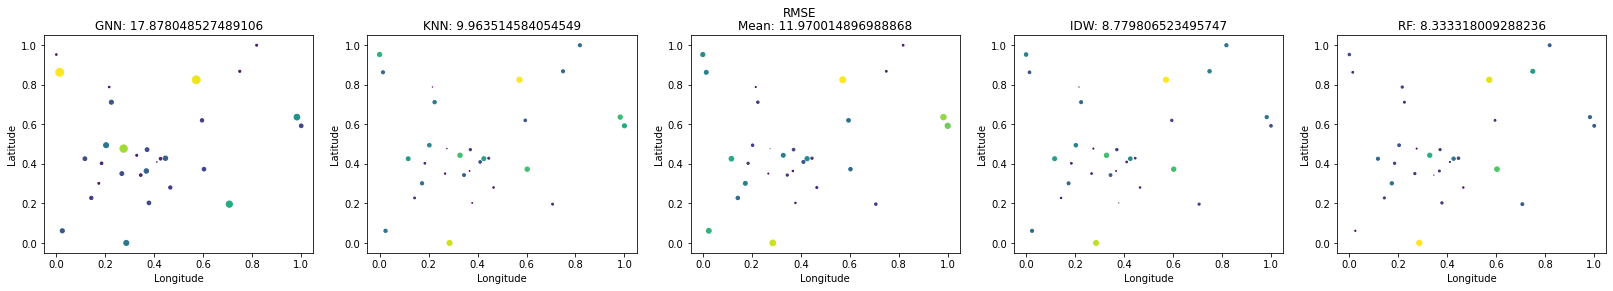

KNN RMSE:  18.663040407622855
Mean RMSE:  19.746898708865047
IDW RMSE:  17.424317043892714
RF RMSE:  16.309068103391493
LR RMSE:  16.853559384743374
GNN RMSE:  30.85220041759312


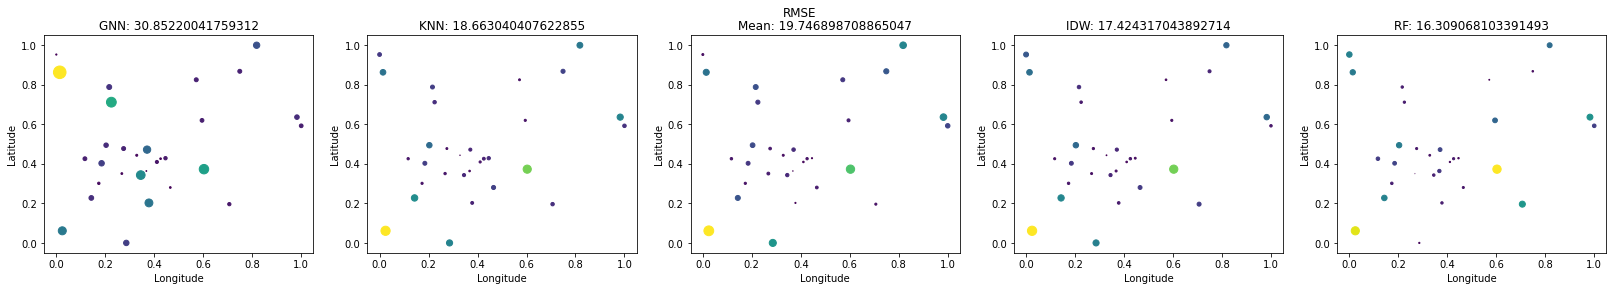

KNN RMSE:  31.746712273235122
Mean RMSE:  30.425163601711393
IDW RMSE:  31.342373986509543
RF RMSE:  27.00783335772604
LR RMSE:  33.42726619330545
GNN RMSE:  42.537054972723126


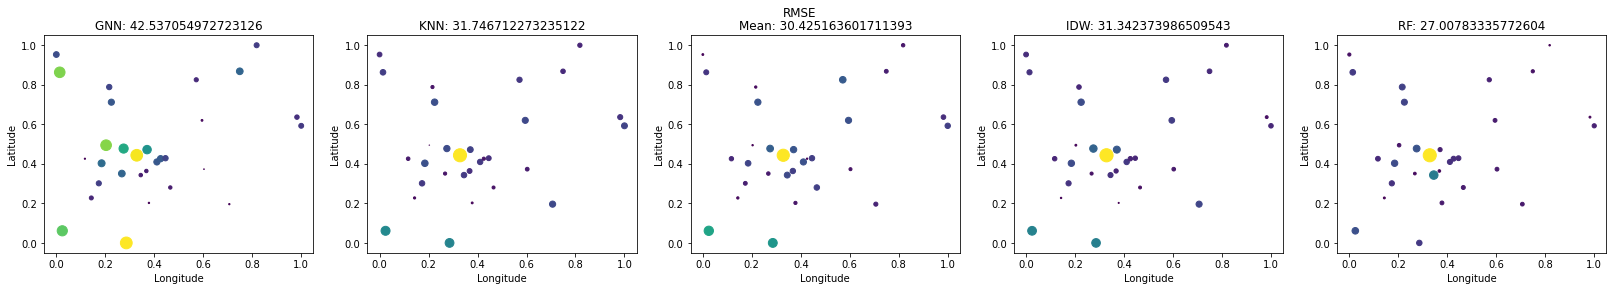

KNN RMSE:  25.187498368260762
Mean RMSE:  31.02298507411033
IDW RMSE:  20.658217089938525
RF RMSE:  21.379765724849513
LR RMSE:  26.628844019708534
GNN RMSE:  37.88085902128368


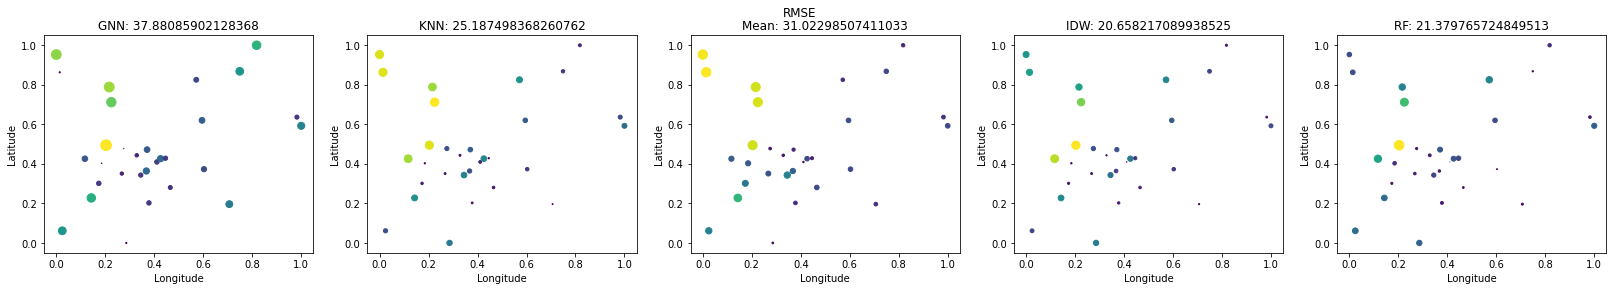

KNN RMSE:  6.740971813925231
Mean RMSE:  7.305747560178861
IDW RMSE:  5.659134995830198
RF RMSE:  6.1335720697010405
LR RMSE:  7.243298808066174
GNN RMSE:  10.114500572920466


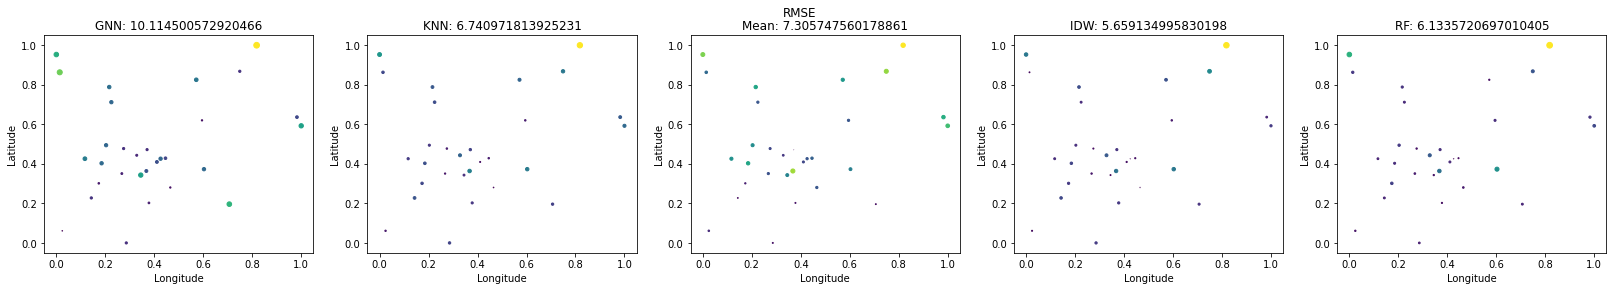

KNN RMSE:  26.369517365594707
Mean RMSE:  35.54974063038826
IDW RMSE:  25.130575075581365
RF RMSE:  25.68774858374298
LR RMSE:  26.335340046385923
GNN RMSE:  62.382550898691015


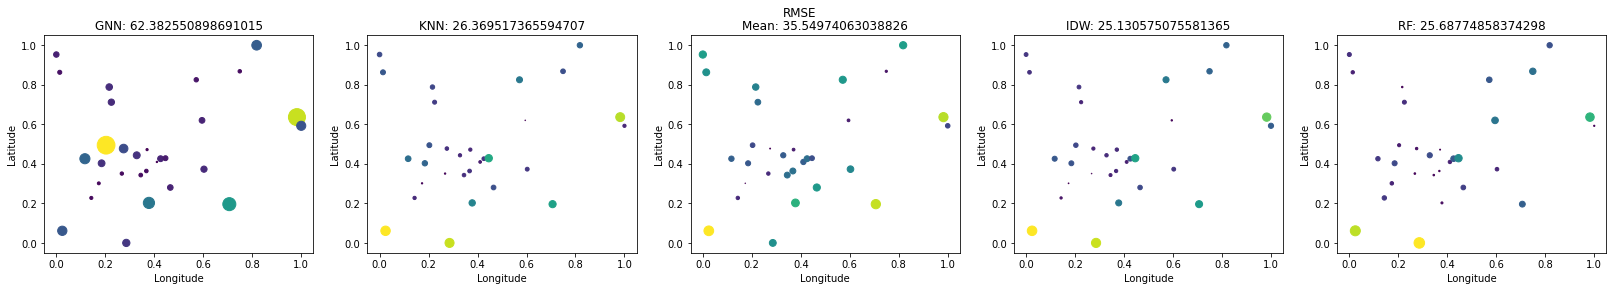

KNN RMSE:  32.745835519830386
Mean RMSE:  30.400001728534708
IDW RMSE:  32.98461683232679
RF RMSE:  33.89163499976545
LR RMSE:  30.50128139952819
GNN RMSE:  30.11993651688099


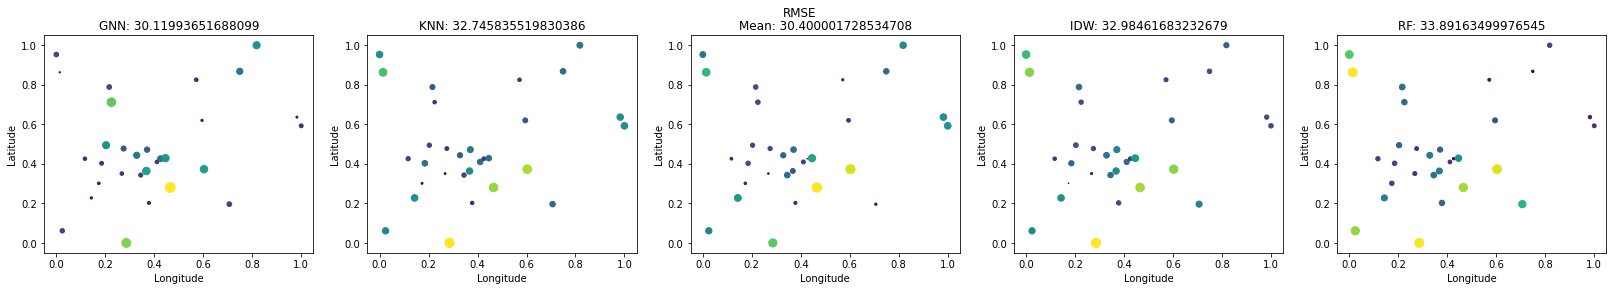

In [5]:
p = pd.date_range(start='2014-05-01 00:00:00', end='2014-12-01 00:00:00', freq = '1M').to_frame(name='dates')

for i in p['dates']:
    d_i = loocv(i)
    d_i = pd.DataFrame(d_i)
    print('KNN RMSE: ', np.mean(d_i['knn rmse']))
    print('Mean RMSE: ', np.mean(d_i['mean rmse']))
    print('IDW RMSE: ', np.mean(d_i['idw rmse']))
    print('RF RMSE: ', np.mean(d_i['rf rmse']))
    print('LR RMSE: ', np.mean(d_i['lr rmse']))
    print('GNN RMSE: ', np.mean(d_i['gnn rmse']))
    
    plt.figure(figsize = (28,4))
    plt.suptitle('RMSE')
    plt.subplot(1, 5, 1)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['gnn rmse'], c = d_i['gnn rmse'])
    title = 'GNN: ' + str(np.mean(d_i['gnn rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 2)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['knn rmse'], c = d_i['knn rmse'])
    title = 'KNN: ' + str(np.mean(d_i['knn rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 3)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['mean rmse'], c = d_i['mean rmse'])
    title = 'Mean: ' + str(np.mean(d_i['mean rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 4)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['idw rmse'], c = d_i['idw rmse'])
    title = 'IDW: ' + str(np.mean(d_i['idw rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 5)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['rf rmse'], c = d_i['rf rmse'])
    title = 'RF: ' + str(np.mean(d_i['rf rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()